## Can a simple urine test detect pancreatic cancer?

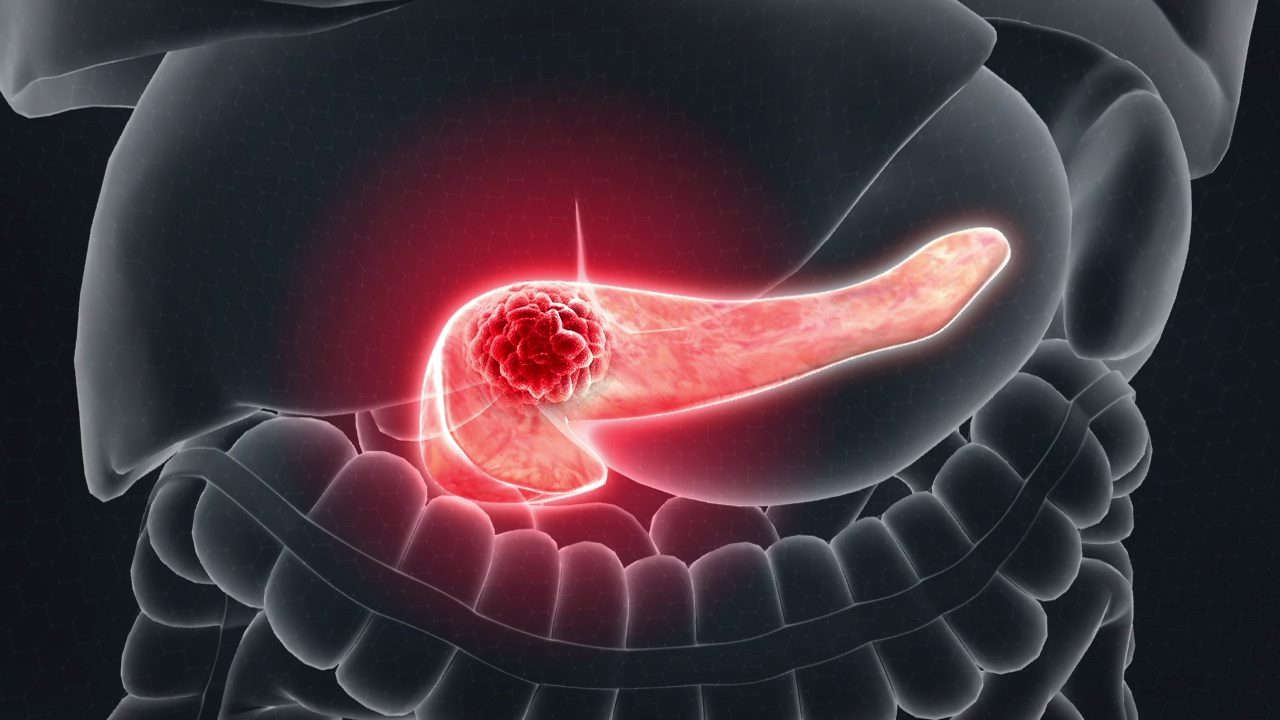

### Introduction

Pancreatic ductal adenocarcinoma (PDAC) is one of the most aggressive and incurable cancers. PDAC patients have a median survival of 5–6 months and there is only around 9% of individuals surviving more than 5 years. The poor outcome is mainly due to late diagnosis; however, if the disease is detected at an early stage, when tumors are still small and localized, the 5-year survival rate can increase to up to 70%. 

Currently, there are no no useful biomarkers for earlier detection of PDAC. The only biomarker in clinical practice, serum CA19-9, is not specific or sensitive enough for screening purposes, and is mainly used as a prognostic marker and for monitoring response to treatment. Thus, the development of a non-invasive test for the early detection of PDAC is essential, presumably to improve the chances of patients’ survival.

A multi-national team of researchers sought to develop an accurate diagnostic test for PDAC. Silvana Debernardi and colleagues published a paper in the journal PLOS Medicine on December 10th, 2020. In this paper, they gathered a series of biomarkers from the urine of three groups of patients:\

1. Healthy controls
2. Patients with non-cancerous pancreatic conditions, like chronic pancreatitis
3. Patients with pancreatic ductal adenocarcinoma

When possible, these patients were age- and sex-matched. Our goal is **developing an accurate model to identify patients with pancreatic cancer**, and more specifically, to differentiate between 3 (pancreatic cancer) versus 2 (non-cancerous pancreas condition) and 1 (healthy) by taking advantage of this published dataset.

### Data Wrangling

[Data Wrangling Notebook](https://github.com/xonic64/Capstone2/blob/c9678988f7643c86e6426b4da1a50f4a3e5590d8/7.6_Capstone%202_Data%20Wrangling.ipynb)

The key data source is a single CSV file, with 590 rows and 14 columns, which can be downloaded from [kaggle.com](https://www.kaggle.com/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer). The key features are five urinary and one plasma biomarkers that are listed as follows:

 - **Creatinine** is a protein that is often used as an indicator of kidney function.
 - **YVLE1** is lymphatic vessel endothelial hyaluronan receptor 1, a protein that may play a role in tumor metastasis.
 - **REG1B** is a protein that may be associated with pancreas regeneration.
 - **TFF1** is trefoil factor 1, which may be related to regeneration and repair of the urinary tract.
 - **REG1A** is a protein that may be associated with pancreas regeneration.
 - **Plasma CA19-9** is a monoclonal antibody that is often elevated in patients with pancreatic cancer. 
 
Keep in mind that some biomarkers were not measured in all patients, i.e. REG1A and plasma CA19-9 were only assessed in 306 and 350 patients, respectively. **Age** and **sex**, both included in the dataset, may also play a role in predicting pancreatic cancer. Additionally, the dataset includes information on the stage of pancreatic cancer, and diagnosis for non-cancerous patients, which should never be treated as predictor features in the first place. This information will not be available because our goal is to predict the presence of pancreatic cancer before diagnosis.

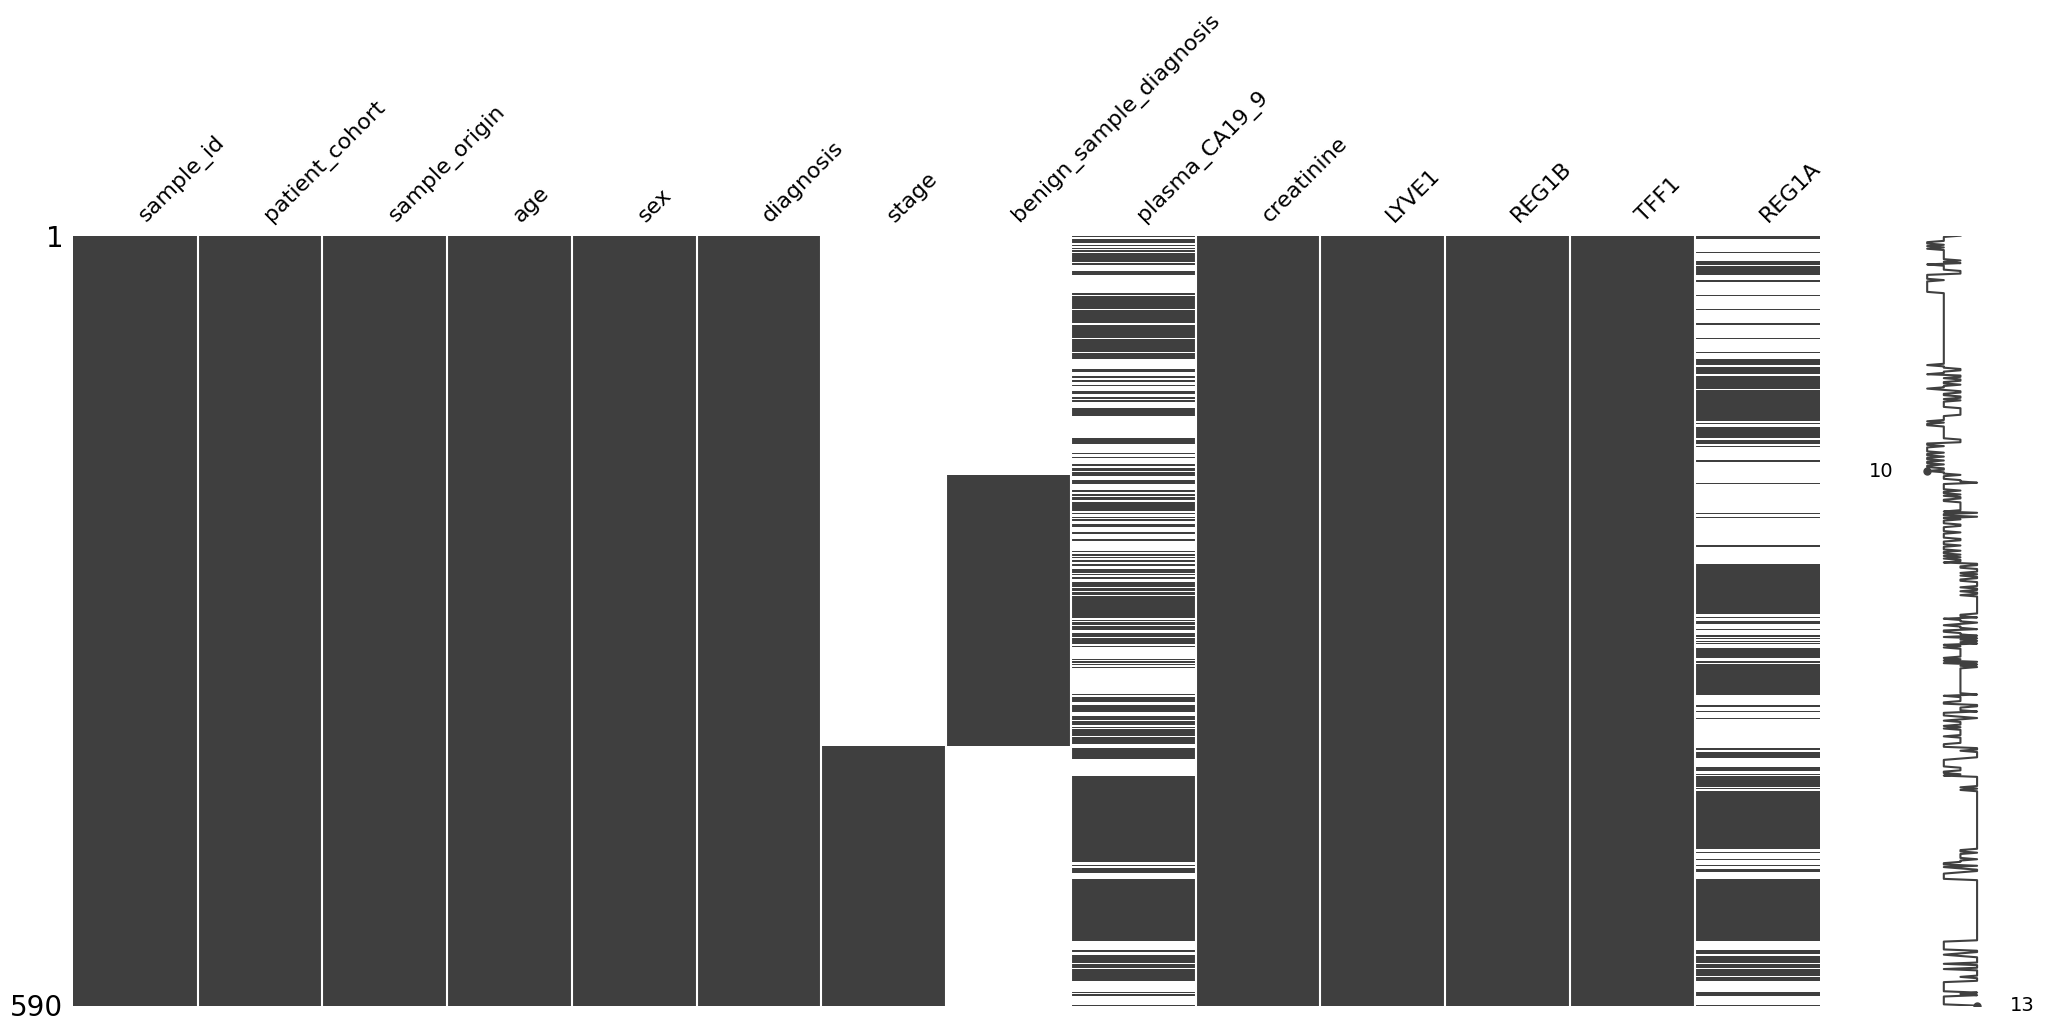

> Visualization of missingness matrix

The dataset is relatively clean and does not require extensive wrangling since it has already been published in a peer-reviewed journal. After looking into the categorical features, we learned that all of the 590 samples were collected from four different origins in two separate cohort studies. These two categorical variables should not, theoretically, play any role in predicting diagnosis. 

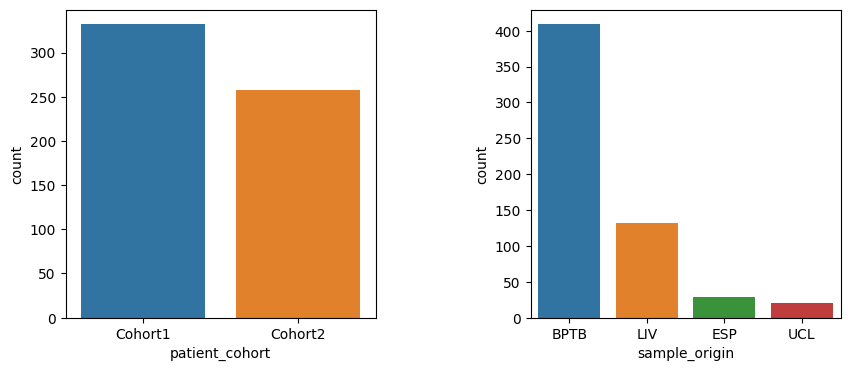

> Patient samples were collected from four different locations in two cohort studies.

The number of patients in each diagnosis category is quite even, with 199 pancreatic cancers (diagnosis 3), 208 non-cancerous patients with pancreas conditions (diagnosis 2) and 183 healthy controls (diagnosis 1). In this case we will not have to be extra cautious about imbalance in our dataset since this is a 3-class multi-classification task. However, there is indeed some imbalance in the detailed distribution of patients with diagnosis 2 and 3. If the problem was to predict the subcategory of these patients, we would have to deal with the potential problem caused by the imbalance in these sub-categories. 

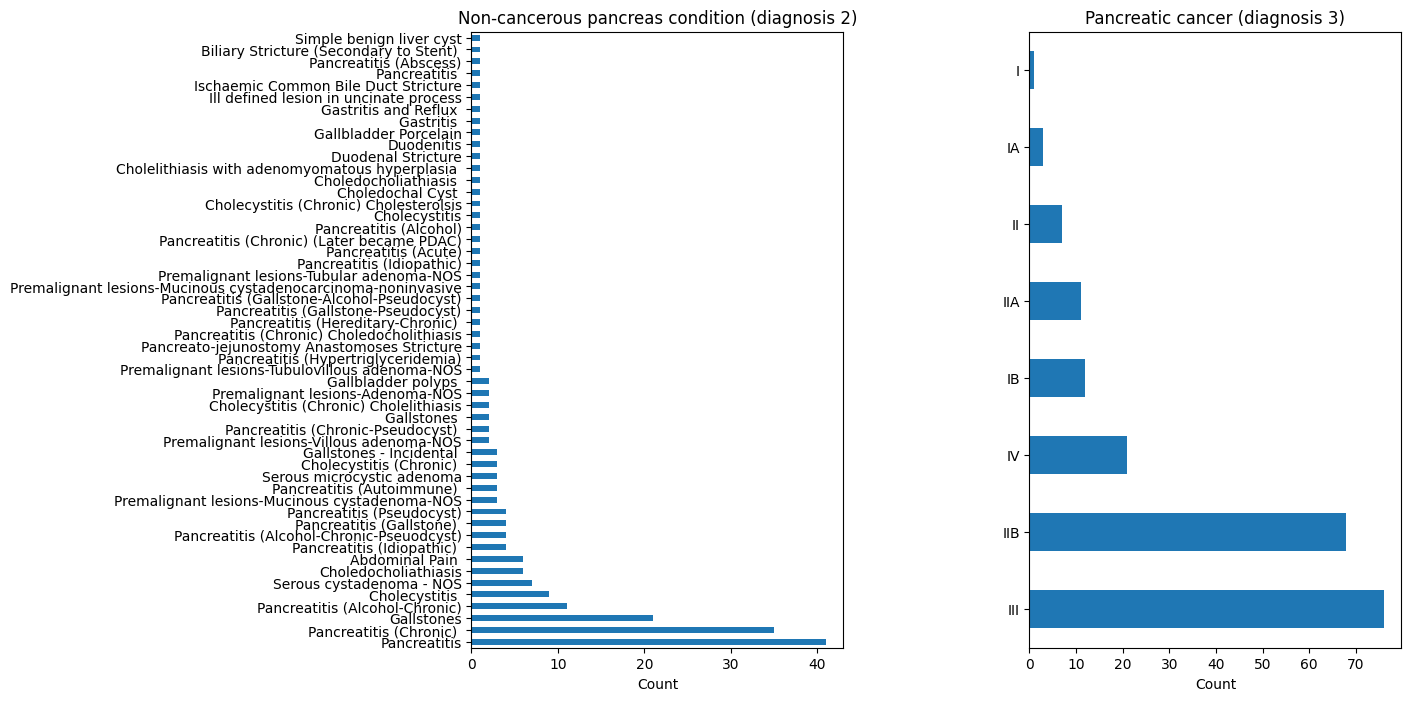

> Detailed distribution of patients with non-cancerous pancreas condition (diagnosis 2) and pancreatic cancer (diagnosis 3)

We will further explore the numeric variables in the dataset. By using the `.describe()` method, we found that there were two columns, `'plasma_CA19_9'` and `'REG1A'`, with minimum values equal to zero. After looking into these two columns, we realized these were only one sample with 0 U/ml plasma CA19-9 and 7 samples with 0 ng/mL REG1A. These 0s were most likely replaced by original authors. The replacement could be concerning and might confound the analysis. Thus, we may have to consider replacing these 0s with NaN first, and impute these missing values with median later.

Finally, we investigate the distribution of feature values in each diagnosis category. It looks like elderly people are more vulnerable to pancreatic cancer since the age distribution shifts towards right specifically in patients with pancreatic cancer (diagnosis 3). Men are more susceptible to pancreatic cancer and non-cancerous pancreas conditions than women as shown in the sex distribution. There are several urinary biomarkers, including plasma CA19-19, LYVE1, REG1B, TFF1, and REG1A, that are highly elevated in patients with pancreatic cancer and non-cancerous pancreas conditions compared with healthy controls.

### Exploratory Data Analysis (EDA)

[EDA Notebook](https://github.com/xonic64/Capstone2/blob/c9678988f7643c86e6426b4da1a50f4a3e5590d8/11.5_Capstone%202_EDA_updated.ipynb)

We applied Principal Component Analysis (PCA), a dimensionality reduction technique, to visualize high dimensional data. In this initial step of EDA, we would only choose numeric features and not include any missing values in all the six biomarkers. Since PCA is sensitive to scale, to ensure equal contribution of all the numeric features, we first applied the `scale()` function, and then fit the PCA transformation using the scaled data. The cumulative variance ratio explained by the first and second PCA component was only about 57% in this case.

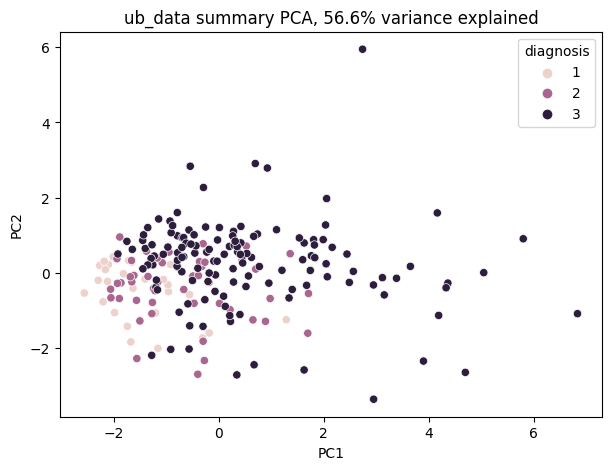

We further applied the `.components_` attribute of the fitted PCA object, which taught us how important (and in what direction) each feature contributes to each score (or coordinate on the plot). For the row associated with the first component, it looked like `'TFF1'`, `'REG1B'`, `'LYVE1'`, and `'REG1A'` might count for quite a lot, in a positive sense. For the row associated with the second component, `'creatinine'`, `'plasma_CA19_9'`, and `'age'` might play a role.

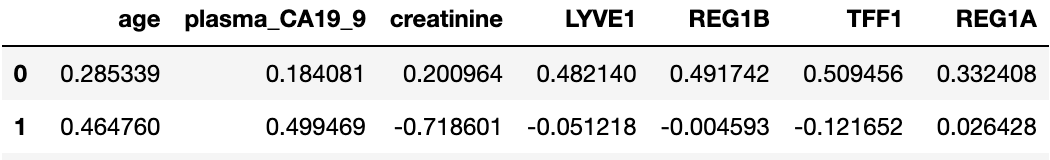

> The .components_ attribute of the fitted PCA object

We also identified that there was a relatively strong correlation between our target feature, `'diagnosis'`, and `'LYVE1`' respectively, followed by other predictor features, `'TFF1'`, `'REG1B'`, and `'REG1A'`. In addition to the correlation between our dependent and independent variables, our independent variables, e.g. `'TFF1'`, `'REG1B'`, `'LYVE1'`, and `'REG1A'`, were highly correlated with each other as well. Therefore, we have to choose the following machine learning algorithms wisely because some of them cannot learn interactions between features.

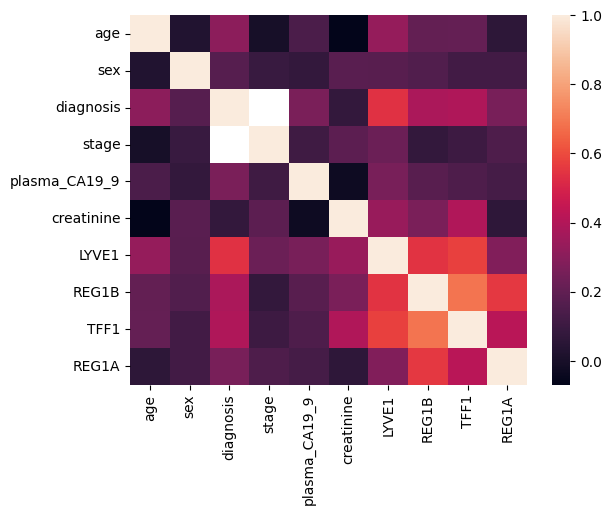

> Heatmap of correlation between numerical features

### Pre-processing and Training Data Development

[Pre-processing & Training Data Development Notebook](https://github.com/xonic64/Capstone2/blob/c9678988f7643c86e6426b4da1a50f4a3e5590d8/16.4.1_Capstone%202_Pre-processing%20and%20Training%20Data%20Development.ipynb)

In the following model preprocessing stage, we prepared our data ready for fitting models according to the previous analyses. In the initial data wrangling stage, we saw that there were lots of missing values in `'stage'` and `'benign_sample_diagnosis'` because only cancer patients (diagnosis #3) and those with non-cancerous pancreas conditions (diagnosis #2) had information of `'stage'` and `'benign_sample_diagnosis'`, respectively. Thus, these two columns should not be treated as predictor (independent) variables and we removed both of them plus the `'sample_id'` column from the original dataset.

We first looked into categorical variables and created dummy or indicator features for them. We already knew that  these categorical columns were all nominal data with low cardinality which can be one-hot encoded later. As a result, we converted the `'sample_origin'` column to a one-hot encoded data frame and created dummy variables for the `'sex'` and `'patient_cohort'` columns. Keep in mind that double representation (collinearity) of sex transformation using one-hot encoding can cause instability in our models. In this case, dummy encoding is more appropriate for sex transformation. 

We then explored the numeric data summary. In our previous analysis, we learned that the 0s in both `'plasma_CA_19_9'` and `'REG1A'` columns were most likely the replacement of NaN. We had to replace these 0s with NaN and filled all the missing values with medians of the columns later. We also investigated the distributions of our feature values. The distribution of all the six biomarkers was highly skewed towards the left and had a long right tail. Thus, we had to perform a log transformation after imputation. Finally, we scaled our features since most of the models, besides tree-based models, are very sensitive to unscaled features. 

Notably, we had to first split our data into training and test sets before we performed any aforementioned preprocessing to our data. The main purpose was to avoid data leakage. To facilitate the whole process, we generated a preprocessing pipeline to fill missing values, log-transform and standardize the magnitude of numeric features at once. This pipeline of preprocessing was trained only on the training set, and the same pipeline was thereafter applied to the test set.

### Modeling

[Modeling Notebook](https://github.com/xonic64/Capstone2/blob/c9678988f7643c86e6426b4da1a50f4a3e5590d8/18.3.1_Capstone%202_Modeling.ipynb)

It is now the show time to develop a final machine learning model that effectively predicts the diagnosis outcome of patients. This is a multi-class classification problem because our goal is to distinguish 3 (pancreatic cancer) versus 2 (non-cancerous pancreas condition) and 1 (healthy). In our previous EDA, we learned that there was a relatively strong correlation between some of our features. Thus, we chose the following machine learning algorithms for further analysis, but not Naive Bayes, which can not learn interactions between features.

* Logistic Regression (logreg)
* K-nearest Neighbors (KNN)
* Decision Tree Classifier (dtc)
* Random Forest Classifier (rfc)
* Gradient Boosting Classifier (gbc)
* Support Vector Machine (svc)

We first did a quick comparison for all the six classification models with default settings and examined which one performed the best out of the box. Three of the models, logreg, rfc, and svc, had the average of accuracy around 75%, while KNN and dtc had a significantly lower score compared with the other competitors. Keep in mind that this was just a quick comparison without any optimization. In the next step, we further fine tuned each model and investigated if the final result is aligned with our initial evaluation after hyperparameter tuning.

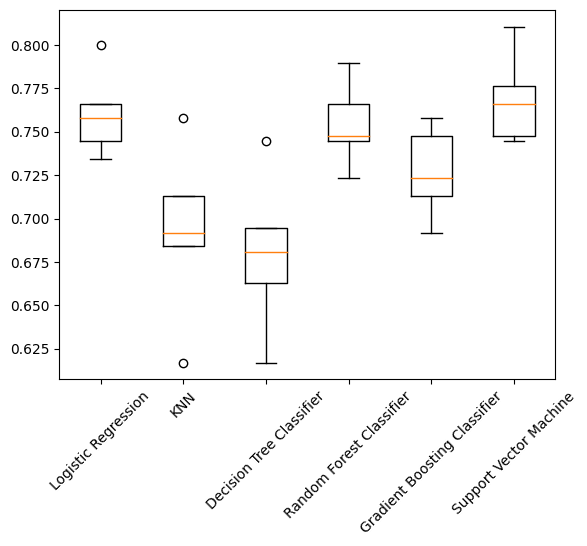

> Visualization of model performance between multiple classification algorithms without tuning

We implemented either the grid search or random search cross-validation for identifying the best hyperparameter value, depending on the run time. After hyperparameter tuning, three were only three models, logreg, rfc, and svc, with an accuracy score larger than 76%. This final result was consistent with our aforementioned observation. We further looked into these three top candidates and compared their performance. Since this was a three-class multi-classification task, we specifically investigated the following evaluation metrics: **average accuracy, f1-score, and log-loss**. We also assessed the confusion matrix and examined if these performance metrics could further guide us on model selection.

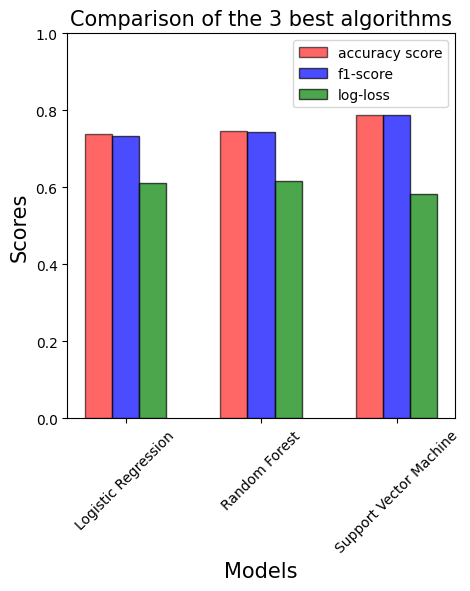

We clearly saw that Support Vector Machine (svc) has the highest accuracy 78.8% and f1-score 78.7% with the lowest log-loss 58.2% compared with the other two competitors. In this case, **the final winner for this project is svc**. Keep in mind that svc is memory-intensive, hard to interpret, and kind of annoying to run and tune.

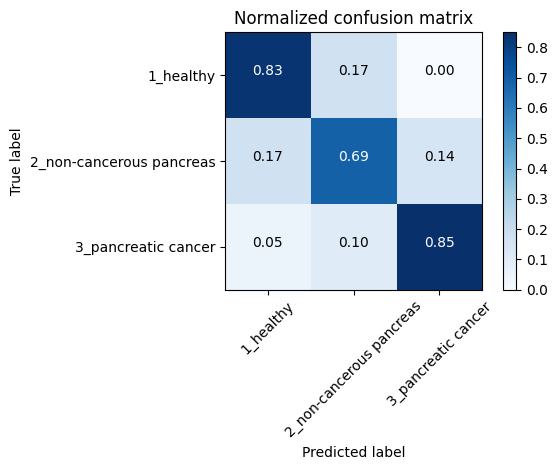

> Normalized confusion matrix for Support Vector Machine Classifier (svc)

The runner-up algorithm for this project is Random Forest Classifier (rfc) since it has a decent accuracy 74.6% and f1-score 74.4%. Notably, it has the highest recall score 88% for the class of pancreatic cancer which could be useful if identifying cancer patients is the first priority. Although Logistic Regression (logreg) is not on the top of our favorites, it can take in new data using an online gradient descent method and easily be updated. Both svc and rfc do not support online learning, so we have to rebuild our models when new examples come in.

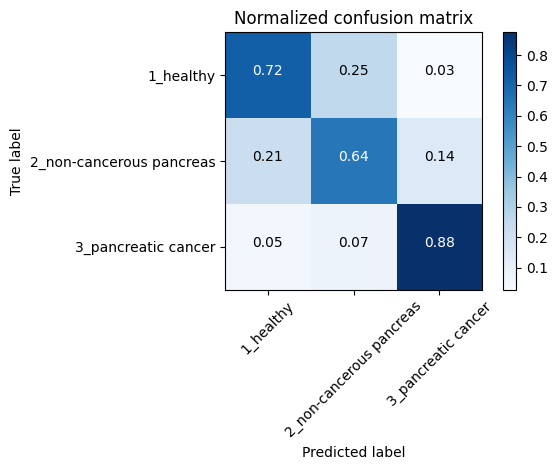

> Normalized confusion matrix for Random Forest Classifier (rfc)

At the end, we tried to validate one of the conclusions in the original paper: Urine REG1B outperforms REG1A in detecting early stage PDAC. By plotting feature importances using Random Forest, we demonstrated the top 10 feature importances in our rfc model to gain a perspective on which features were driving the model predictions. The result clearly showed that REG1B was indeed more important than REG1A in our bar plot of feature importance derived from Random Forest, which was consistent with the original paper and our previous PCA in EDA. Therefore, we should prioritize REG1B over REG1A if we want to limit sample collections and reduce cost.

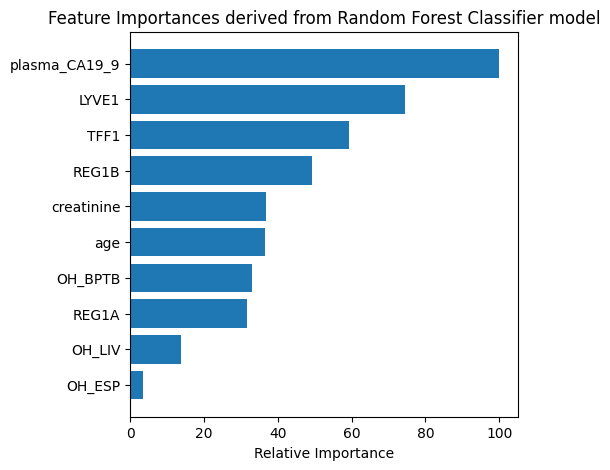

### Conclusion

We successfully developed a supervised machine learning model with decent performance metrics by implementing Support Vector Machine Classifier, which presents a potential approach to detect PDAC in a non-invasive manner.

### Future Directions

* Although our final svc model had a decent f1-score for identifying PDAC (diagnosis #3), it did not perform as well to differentiate patients with non-cancerous pancreas conditions (diagnosis #2). The f1-score for this category was the lowest among the three groups, which was evident in all the top three models we tested. We may have to collect more data (patients) and/or more features (biomarkers) to augment the predictive power for this specific class.
* The overall performance of our model could also be improved by connecting to a secured online database so that the model can be updated with new data on a regular basis. However, we have to reconsider model selection since not all of them support online learning.
* Due to CPU constraints, we could only include some of the most common hyperparameters for tuning and explore finite values in each of them. It would be interesting to find out if we can improve our model performance by further optimizing the hyperparameter tuning process.

